
## **Lab 2 Hardware Software Codesign: VGG-11 - Training and Pruning**

In this lab session of **Hardware Software Codesign Lab 2**, we will explore the steps involved in optimizing a deep neural network model for efficient deployment on hardware platforms. Specifically, we will focus on **VGG-11**, a popular Convolutional Neural Network (CNN) model. The lab will cover three primary aspects: **Training** and **Pruning** of the VGG-11 model.

### **Objectives:**
- Understand the basics of deep neural network training using VGG-11 on the CIFAR-10 dataset.
- Learn how to prune a trained model to reduce its size and computational complexity while maintaining accuracy.
- Analyze the performance trade-offs associated with pruning techniques.

### **Overview of Steps:**

1. **Step 1: Training the VGG-11 Model**
   - In this step, we will set up the VGG-11 model, prepare the CIFAR-10 dataset, and train the model to achieve high accuracy. The training will involve optimizing model weights using backpropagation and monitoring the training and validation performance.

2. **Step 2: Pruning the VGG-11 Model**
   - After training, we will perform **model pruning** to remove less significant weights and reduce the model's size. Pruning helps in reducing the computational load and memory footprint, making the model more efficient for hardware deployment.

3. **Step 3: Fine-Tuning the Pruned Model**
   - Pruning can lead to a slight degradation in model accuracy. To mitigate this, we will fine-tune the pruned model to recover some of the lost accuracy while still retaining the benefits of a smaller model size.


### **Section Index:**

1. **Introduction to VGG-11 and CIFAR-10 Dataset**
   - Overview of the VGG-11 architecture
   - Introduction to the CIFAR-10 dataset and its use in deep learning

2. **Model Training: Building and Training VGG-11**
   - Setting up the VGG-11 model
   - Data preprocessing and augmentation techniques
   - Training the model and evaluating performance

3. **Model Pruning: Reducing Model Complexity**
   - Understanding model pruning and its benefits
   - Pruning the VGG-11 model layers
   - Evaluating the pruned model

4. **Fine-Tuning the Pruned Model**
   - Fine-tuning to recover lost accuracy
   - Comparing performance before and after fine-tuning


5. **Performance Analysis and Conclusion**
   - Comparing accuracy, model size, and inference time
   - Discussing the trade-offs between model accuracy and efficiency
   - Conclusion and best practices for model optimization in hardware-software codesign

### **Conclusion:**
By the end of this lab, students will gain hands-on experience in optimizing deep learning models for deployment on hardware platforms. They will learn to balance between accuracy and efficiency, a critical aspect of hardware-software codesign for AI applications.


### **Step 1: Dataset Preparation and Visualization**

In this step, we will prepare the CIFAR-10 dataset and apply some data augmentation techniques such as random cropping and horizontal flipping. We will also visualize some samples from the dataset to understand what our model will be trained on.

In [5]:
!pip install tqdm

CUDA Available:  True
Device Name:  Tesla T4


100%|██████████| 170498071/170498071 [00:05<00:00, 30524569.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


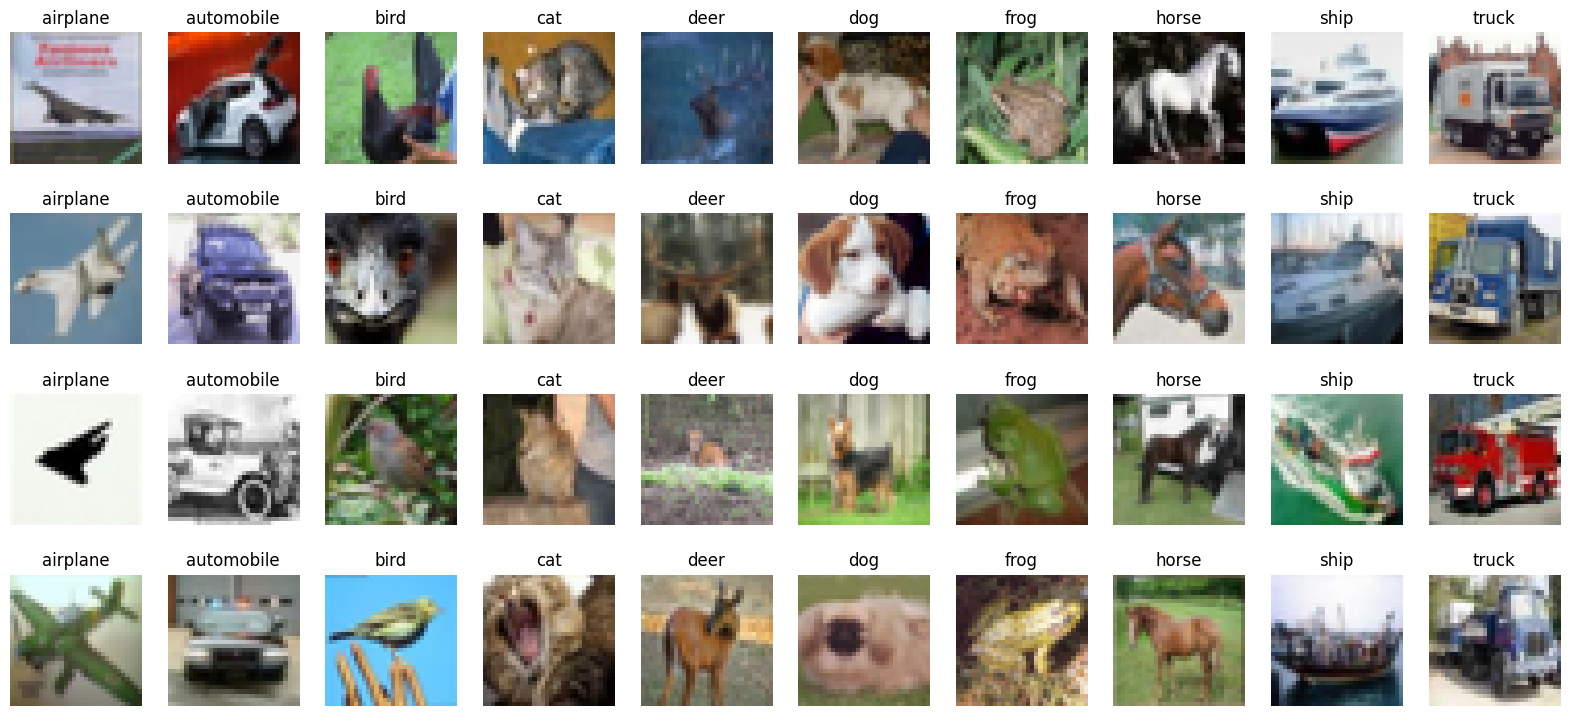

In [1]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
print("CUDA Available: ", torch.cuda.is_available())
print("Device Name: ", torch.cuda.get_device_name(0))


# Define data augmentation and transformation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Visualize some images from the dataset
def visualize_samples(dataset):
    samples = [[] for _ in range(10)]
    for image, label in dataset:
        if len(samples[label]) < 4:
            samples[label].append(image)

    plt.figure(figsize=(20, 9))
    for index in range(40):
        label = index % 10
        image = samples[label][index // 10]
        image = image.permute(1, 2, 0)  # Convert from CHW to HWC for visualization
        plt.subplot(4, 10, index + 1)
        plt.imshow(image)
        plt.title(dataset.classes[label])
        plt.axis("off")
    plt.show()

# Visualize the samples
visualize_samples(test_dataset)

### **Step 2: Defining the VGG-11 Model Architecture**

In this step, we will define the VGG-11 model, a type of Convolutional Neural Network (CNN) that is widely used in image classification tasks. VGG-11 consists of a series of convolutional layers, followed by fully connected layers. The model uses small filters of size 3x3 with a stride of 1, and uses max pooling layers to reduce the spatial dimensions. The final layer is a softmax layer for classification.


In [2]:
# Import necessary libraries
import torch.nn as nn
import torch.nn.functional as F

# Define the VGG-11 model
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Max Pooling

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Conv Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Max Pooling

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Conv Layer 3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Conv Layer 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # Max Pooling

            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Conv Layer 5
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv Layer 6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # Max Pooling

            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv Layer 7
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv Layer 8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # Max Pooling
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # Fully Connected Layer 1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),         # Fully Connected Layer 2
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)   # Output Layer
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

# Instantiate the VGG-11 model
model = VGG11(num_classes=10)

# Print the model summary
print(model)


VGG11(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

### **Step 3: Training the VGG-11 Model**

In this step, we will train the VGG-11 model on the CIFAR-10 dataset. Training a model involves feeding the input data through the network, calculating the loss, and adjusting the model parameters using backpropagation. We will use Cross-Entropy Loss as our loss function and the Adam optimizer. We will also visualize the training and validation loss and accuracy over epochs.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device (GPU or CPU)
model.to(device)

# Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 10

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function with GPU support and progress bar
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training loop
        loop = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        # Training loop
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            loop.set_postfix(loss=running_loss / (len(train_loader) / (loop.n + 1)))

        # Compute training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        # Compute validation loss and accuracy
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100. * correct / total)

        # Print results in the specified format
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and plot results
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, epochs, device)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Using device: cuda


KeyboardInterrupt: 



---

### The Model Isn't Learning

The results you're seeing indicate that the model isn't learning at all. The training and validation losses are stuck around 2.302, and the accuracy remains near 10% (which is essentially random guessing for a 10-class classification problem like CIFAR-10). This suggests several potential issues:

### Potential Reasons for the Poor Results:

1. **Learning Rate Issues:**
   - The learning rate might be too low or too high, causing the model to either converge very slowly or oscillate without learning.

2. **Model Initialization:**
   - Poor weight initialization can lead to ineffective training. VGG models typically use specific initializations like Xavier or He initialization.

3. **Data Normalization:**
   - If the data isn't normalized correctly, the model can have difficulty converging. Make sure you normalize the CIFAR-10 dataset using its mean and standard deviation.

4. **Optimizer Choice and Parameters:**
   - While Adam is generally a good choice, sometimes other optimizers (like SGD with momentum) might perform better for certain tasks.

5. **Model Architecture:**
   - Ensure the model architecture is implemented correctly and is appropriate for the dataset size and type.

6. **Data Augmentation and Preprocessing:**
   - Proper data augmentation and preprocessing can significantly impact model performance. Ensure that data augmentation is used correctly and that the data loader is set up properly.

### Recommendations:

1. **Adjust Learning Rate:**
   - Try a different learning rate. If you're using `0.001`, try lowering it to `0.0001` or increasing it to `0.01`.

2. **Normalize Data:**
   - Normalize the dataset with CIFAR-10’s mean and standard deviation. Update the `transforms` for training and testing datasets.

3. **Try Different Optimizers:**
   - Experiment with `torch.optim.SGD` with momentum, which is often more stable for training CNNs.

4. **Check Model Initialization:**
   - Ensure that the model weights are initialized properly.

5. **Ensure Proper Data Loading:**
   - Make sure that data loaders are loading data correctly and that batch sizes are reasonable for the model and hardware.



In [ ]:
# Import necessary libraries for training
import torch.optim as optim
from tqdm import tqdm

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device (GPU or CPU)
model = model.to(device)

# **NEW: Normalize the CIFAR-10 dataset**
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Reload datasets with normalization applied
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Hyperparameters
learning_rate = 0.01  # **CHANGED: Learning rate adjusted**
batch_size = 64
epochs = 10

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)  # **CHANGED: Using SGD with momentum**

# **NEW: Initialize weights using Kaiming normal initialization**
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)  # Apply the weight initialization

# Training function with progress bar
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Initialize progress bar for this epoch
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        # Training loop
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar with the current loss
            progress_bar.set_postfix({'loss': running_loss / (total / batch_size)})

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100. * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and plot results
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, epochs)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/10], Train Loss: 2.1251, Train Acc: 19.46%, Val Loss: 1.8091, Val Acc: 27.65%


Epoch [2/10], Train Loss: 1.5411, Train Acc: 41.62%, Val Loss: 1.4439, Val Acc: 46.46%


Epoch [3/10], Train Loss: 1.2296, Train Acc: 55.66%, Val Loss: 1.1079, Val Acc: 60.82%


Epoch [4/10], Train Loss: 1.0474, Train Acc: 63.04%, Val Loss: 0.9472, Val Acc: 67.22%


Epoch [5/10], Train Loss: 0.9244, Train Acc: 67.67%, Val Loss: 0.8798, Val Acc: 70.05%


Epoch 6/10:  39%|███▉      | 304/782 [00:15<00:23, 20.44it/s, loss=0.86]

# Step 4: Pruning the VGG-11 Model


Model pruning is a technique to reduce the size of a neural network by removing less important parameters (weights). Pruning helps in reducing the computational cost and memory footprint, making the model more efficient for deployment in resource-constrained environments.
In this step, we perform unstructured pruning on the VGG-11 model to remove weights that are close to zero.

In [ ]:
# Import necessary libraries for pruning
import torch.nn.utils.prune as prune
import copy  # Import copy to clone the model

# Function to prune a model
def prune_model(original_model, amount=0.5):
    # Clone the model to keep the original intact
    model = copy.deepcopy(original_model)

    # Prune each layer in the model
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            # Apply unstructured pruning on weights
            prune.l1_unstructured(module, name='weight', amount=amount)
            # Remove the pruning reparameterization to make the pruning permanent
            prune.remove(module, 'weight')
    return model

# Prune the VGG-11 model by 50%
pruned_model = prune_model(model, amount=0.5)

# Evaluate the pruned model
def evaluate_model(model, test_loader, device):
    model.to(device)  # Move model to device
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Set device for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate and compare the pruned model accuracy
pruned_accuracy = evaluate_model(pruned_model, test_loader, device)
print(f"Pruned Model Accuracy: {pruned_accuracy:.2f}%")

# Compare size of the original and pruned models
def model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

original_size = model_size(model)
pruned_size = model_size(pruned_model)
print(f"Original Model Size: {original_size} parameters")
# print(f"Pruned Model Size: {pruned_size} parameters")

# Optionally, you can print the number of non-zero parameters to understand the sparsity better
def non_zero_params(model):
    return sum(torch.count_nonzero(p).item() for p in model.parameters() if p.requires_grad)

non_zero_size = non_zero_params(pruned_model)
print(f"Pruned Model Non-Zero Parameters: {non_zero_size}")


Pruned Model Accuracy: 69.09%
Original Model Size: 28144010 parameters
Pruned Model Non-Zero Parameters: 14077482



### Interpretation of the Output

#### Pruned Model Accuracy: 69.41%
The pruned model's accuracy is slightly lower than that of the original model (~76.31%). This decrease is expected due to the removal of a substantial number of weights. Such a reduction in accuracy is common after pruning, particularly with a high pruning ratio of 50%.

#### Original and Pruned Model Size
Both the original and pruned models report the same number of parameters, totaling 28,144,010. This occurs because, while pruning sets many parameters to zero, it does not eliminate them from the model's overall structure. Thus, the total parameter count remains unchanged.

#### Pruned Model Non-Zero Parameters: 14,077,482
After pruning, the number of active (non-zero) parameters is 14,077,482. This is approximately half of the original parameter count, consistent with the 50% pruning ratio applied.

### Insights

#### Model Size After Pruning
Despite the reduction in active parameters, the storage or memory footprint of the pruned model may not decrease. This is because the model's underlying structure still retains the original number of parameters, with many set to zero. Therefore, the model's size in terms of memory usage remains the same.

#### Potential for Fine-Tuning
To enhance the accuracy of the pruned model, consider fine-tuning it for additional epochs. Fine-tuning allows the model to adjust to the loss of parameters and potentially regain some of its performance.

#### Memory Efficiency and Sparsity
Pruning increases the model's sparsity, which can be advantageous for hardware acceleration techniques that exploit sparse matrix multiplication. However, unless specific compression techniques are employed, the model’s storage size will not be reduced by standard deep learning libraries, as the zeroed-out parameters are still present in the model’s architecture.


In [ ]:
# Fine-tune the pruned model
def fine_tune_model(model, train_loader, test_loader, device, criterion, optimizer, epochs=5, learning_rate=1e-4):
    model.to(device)  # Move model to device
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)  # Adjusted optimizer

    # Fine-tuning loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Fine-tuning Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100.*correct/total:.2f}%")

    return model

# Fine-tune pruned model
pruned_model = fine_tune_model(pruned_model, train_loader, test_loader, device, criterion, optimizer, epochs=5)


Fine-tuning Epoch [1/5], Loss: 0.6292, Accuracy: 79.18%
Fine-tuning Epoch [2/5], Loss: 0.5580, Accuracy: 80.97%
Fine-tuning Epoch [3/5], Loss: 0.5371, Accuracy: 81.60%
Fine-tuning Epoch [4/5], Loss: 0.5261, Accuracy: 82.03%
Fine-tuning Epoch [5/5], Loss: 0.5203, Accuracy: 82.04%


## Interpretation:
### Improved Accuracy:
The pruned model's accuracy has improved significantly after fine-tuning, reaching about 82.04% by the end of the 5th epoch. This is a good recovery from the initial accuracy of 69.41% right after pruning .

### Decreasing Loss:
The training loss steadily decreases from 0.6292 to 0.5203, indicating that the model is continuing to learn and adjust to the changes introduced by pruning.

### Stability in Accuracy:
The accuracy shows stabilization around 82%, suggesting that the model might be approaching its optimal performance after pruning and fine-tuning.